In [1]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import zstandard as zstd  

In [2]:
tissue = ['BLOOD', 'LIVER', 'LUNG', 'KIDNEY', 'all']

In [3]:
data_d = '~/data/1_Single_Cell_PRS/2_cV2F'
trait = pd.read_csv(f'{data_d}/pheno_tissue.txt', header=None)[0].tolist()

In [7]:
data_d = '~/data/1_Single_Cell_PRS/2_cV2F/mvp_afr_0.9_0.01/20231221/406k_geno_v2_UKB_18PCs/fit_w_val/'

In [8]:
df_evals = []
for ti in tissue:
    for tr in trait:
        #print(data_d + ti + '/' + tr + '/')
        if tr =='INI20030780':
            df = pd.read_csv(data_d + ti + '/' + tr + '/exclude_APOE/snpnet.eval.tsv.gz', sep='\t', compression='gzip')
        else:
            df = pd.read_csv(data_d + ti + '/' + tr + '/snpnet.eval.tsv.gz', sep='\t', compression='gzip',)
        df['Tissue'] = [ti] * len(df)
        df.replace(np.nan, 'All', inplace=True)
        df_evals.append(df)

In [9]:
df_full = pd.concat(df_evals)

In [10]:
filtered = df_full[(df_full['population'] == 'Afr') & (df_full['model'] == 'PGS') & (df_full['split'] == 'test')]

In [11]:
tissue_trait_dict = {'INI30120' : 'BLOOD', 'INI20030780': 'LIVER', 'INI50030700': 'KIDNEY', 'INI1003063': 'LUNG', 'INI10030620': 'KIDNEY'}

In [12]:
def improve_fold(trait, tissue_trait_dict, score, df):
    return score/df[(df['Tissue'] == tissue_trait_dict[trait]) & (df['#response'] == trait)]['eval']

In [13]:
filtered['Improvement'] = filtered.apply(lambda x: improve_fold(x['#response'], tissue_trait_dict, x['eval'], filtered), axis=1)

/tmp/ipykernel_249606/455381963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Improvement'] = filtered.apply(lambda x: improve_fold(x['#response'], tissue_trait_dict, x['eval'], filtered), axis=1)


In [14]:
reversed_dict = {value: key for key, value in tissue_trait_dict.items()}

In [15]:
custom_index_order = ['INI30120', 'INI50030700', 'INI1003063', 'INI20030780']

In [17]:
base_dir = '~/data/1_Single_Cell_PRS/2_cV2F/baselines/406k_geno_v2_UKB_18PCs/fit_w_val'
df_base_eval = []
for tr in trait:
        #print(data_d + ti + '/' + tr + '/')
        if tr =='INI20030780':
            df = pd.read_csv(base_dir + '/' + tr + '/exclude_APOE/snpnet.eval.tsv.gz', sep='\t', compression='gzip')
        else:
            df = pd.read_csv(base_dir + '/' + tr + '/snpnet.eval.tsv.gz', sep='\t', compression='gzip')
        df.replace(np.nan, 'All', inplace=True)
        df_base_eval.append(df)

In [18]:
df_base = pd.concat(df_base_eval)

In [19]:
filtered_base = df_base[(df_base['population'] == 'Afr') & (df_base['model'] == 'PGS') & (df_base['split'] == 'test')]

In [20]:
filtered_match = filtered[filtered['Improvement'] == 1]

In [21]:
def improve_all(trait, score, input_df):
    return score/input_df[(input_df['#response'] == trait) & (input_df['Tissue'] == 'all')]['eval'].iloc[0]

In [22]:
filtered['Improve_from_all'] = filtered.apply(lambda x: improve_all(x['#response'], x['eval'], filtered), axis=1)

/tmp/ipykernel_249606/613556018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Improve_from_all'] = filtered.apply(lambda x: improve_all(x['#response'], x['eval'], filtered), axis=1)


In [23]:
def improve_base(trait, score, input_df):
    return score/input_df[(input_df['#response'] == trait)]['eval'].iloc[0]

In [24]:
filtered['Improve_from_baseline'] = filtered.apply(lambda x: improve_base(x['#response'], x['eval'], filtered_base), axis=1)

/tmp/ipykernel_249606/3455842490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Improve_from_baseline'] = filtered.apply(lambda x: improve_base(x['#response'], x['eval'], filtered_base), axis=1)


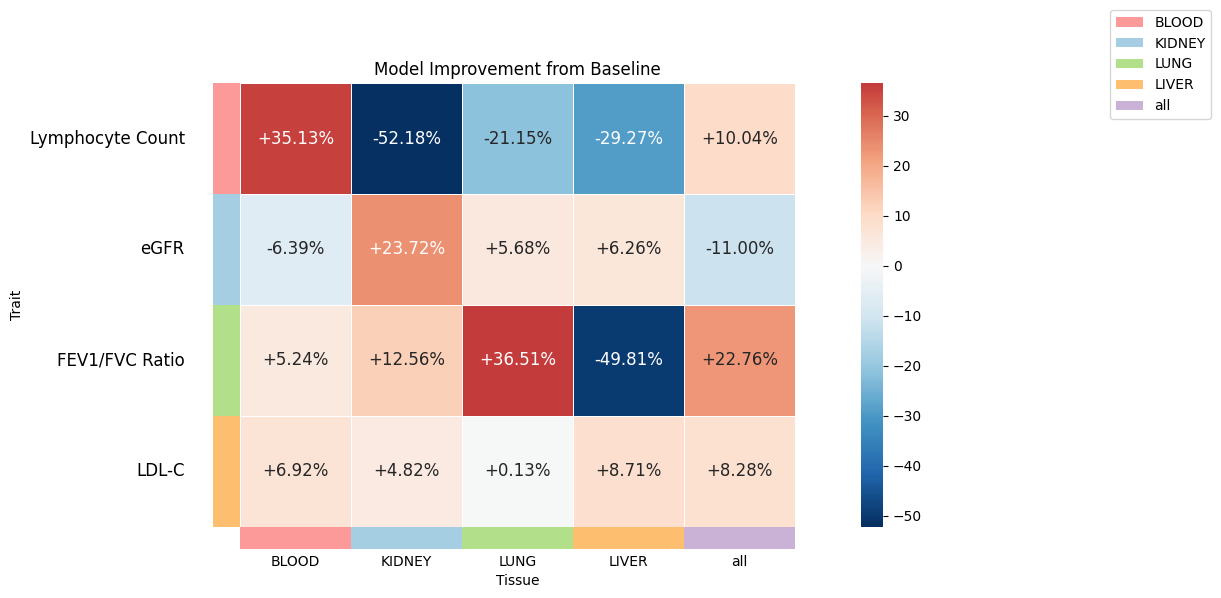

In [37]:
palette = sns.color_palette(palette='Paired')
row_colors = [palette[4], palette[0], palette[2], palette[6]]
col_colors = [palette[4], palette[0], palette[2], palette[6], palette[-4]]

heatmap_input = filtered.pivot(columns='Tissue', index='#response', values='Improve_from_baseline').reindex(index=custom_index_order)

desired_column_order = ['BLOOD', 'KIDNEY', 'LUNG', 'LIVER', 'all']
heatmap_input = heatmap_input[desired_column_order]
heatmap_input = heatmap_input*100 - 100

fig, ax = plt.subplots(figsize=(15, 6))
from matplotlib.patches import Patch
sns.heatmap(heatmap_input, annot=True, fmt=".2f", cmap='RdBu_r', center=0, ax=ax, square=True, yticklabels=['Lymphocyte Count', 'eGFR', 'FEV1/FVC Ratio', 'LDL-C'], xticklabels =desired_column_order, annot_kws={"fontsize":12}, linewidth=.5)

plt.ylabel('Trait')

for i, color in enumerate(row_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.05, i), width=0.05, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))
for i, color in enumerate(col_colors):
    ax.add_patch(plt.Rectangle(xy=(i, -0.05), width=1, height=0.05, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))

# Adjust the spacing between row labels and color bars
ax.tick_params(axis='y', which='major', pad=40, length=0, rotation=0, labelsize=12)
ax.tick_params(axis='x', which='major', pad=20, length=0, rotation=0)

handles = [Patch(facecolor=palette[4], label = 'BLOOD'), 
          Patch(facecolor=palette[0], label = 'KIDNEY'),
          Patch(facecolor=palette[2], label = 'LUNG'),
          Patch(facecolor=palette[6], label = 'LIVER'), 
          Patch(facecolor=palette[-4], label = 'all')]
plt.legend(handles=handles, bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='best')
for t in ax.texts:
    value = float(t.get_text())
    if value > 0:
        t.set_text(f"+{value:.2f}%")
    else:
        t.set_text(t.get_text() + "%")
        
# Set the title
ax.set_title("Model Improvement from Baseline")
plt.tight_layout()
#plt.savefig('Heatmap_improve_base_all_.pdf')